In [1]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc #erfc/Q function
import math
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from IPython.display import clear_output
from scipy import signal
import commpy

In [2]:
def sym_gen(num_sym, M):
    return np.random.randint(low=0, high = M, size=num_sym)

In [3]:
def base_wave(samps_per_sym, f, size, type_wave = 'cos', phase = 0):
    if samps_per_sym/2 > f:
        t = np.arange(0,size,1/samps_per_sym)
        if type_wave == 'cos':
            return np.cos(2*np.pi*f*t + phase)
        else:
            return np.sin(2*np.pi*f*t + phase)
    else:
        return print('[ERROR] Smps/2 > f')

## Ruido
Temos que \\[\gamma = SNR = E_b/N_0\\] ou \\[\gamma = SNR = E_s/N_0\\]

Temos também que \\[P = L \times \frac{1}{N} \sum_{i=0}^{N-1}|s_i|^2\\]

Portanto,

\\[N_0 = P/\gamma\\]

In [4]:
def channel_awgn(sig, EbN0dB, samps_per_sym):
    gamma = 10**(EbN0dB/10)
    P=samps_per_sym*sum(abs(sig)**2)/len(sig) 
    N0=P/gamma 
    
    if np.isrealobj(sig):
        noise = np.sqrt(N0/2)*np.random.standard_normal(sig.shape)
    else:
        noise = np.sqrt(N0/2)*(np.random.standard_normal(sig.shape)+1j*np.random.standard_normal(sig.shape))

    rx_sig = sig + noise
    return rx_sig
    

In [5]:
def Q_function(x):
    return 0.5*erfc(x/np.sqrt(2))

In [6]:
def constellation_psk(M):
    if math.log(M,2).is_integer():
        m = np.arange(0,M)
        I = 1/np.sqrt(2)*np.cos(m/M*2*np.pi)
        Q = 1/np.sqrt(2)*np.sin(m/M*2*np.pi)
        constellation = I + 1j*Q
        #constellation = np.vstack((constellation, m))
        return constellation

In [7]:
def psk_mod_baseband(sym_array, M):
    if math.log(M,2).is_integer():
        constellation = constellation_psk(M)
        remap_sym_cons = constellation[sym_array]
    else:
        return print('[ERROR] M-PSK is not possible')
    
    return remap_sym_cons

In [8]:
def resampling(sym_array, samps_per_sym):
    return np.repeat(sym_array,samps_per_sym)

In [9]:
def matched_filter_RC(alpha, Ts, Fs, size):
    filter_rc = commpy.filters.rcosfilter(int((Ts/Fs)*size), alpha, Ts/2, 1/Fs)[1]
    return filter_rc

In [10]:
def apply_mf(filter_rc, sym_array, Ts, Fs, size):
    sym_array_mf = np.convolve(sym_array, filter_rc, 'full')[int((Ts/Fs)*size/2):int((Ts/Fs)*size/2)+len(sym_array)]*2/(Ts/Fs) 
    return sym_array_mf

In [11]:
def plot_constellation(sig, M):
    constellation = constellation_psk(M)
    plt.scatter(sig.real, sig.imag)
    plt.scatter(constellation.real, constellation.imag)

In [12]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, cutoff, btype='low', fs=fs, analog=False, output = 'sos')
    return sos

def butter_lowpass_filter(data, cutoff, fs, order=5):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfilt(sos, data)
    return y

In [13]:
def sampling(sig, samps_per_sym):
    values = sig[np.arange(samps_per_sym/2,len(sig),np.round((samps_per_sym))).astype(int)]
    return values

In [14]:
def decision(constellation, rx):
    rx_sym = np.array([])
    for symb in rx:
        dif = np.absolute(symb-constellation)
        smallest_difference_index = dif.argmin()
        rx_sym = np.append(rx_sym, smallest_difference_index)
        
    return rx_sym.real

        

In [15]:
def SER_calc(sym_rx, sym_tx, constellation):
    symb_error = np.sum(decision(constellation, sym_rx) != sym_tx)/len(sym_tx)
    return symb_error

## Sincronização

In [16]:
def sincSymbol(symbol_base, rx_symbol):
    corr = signal.correlate(rx_symbol, symbol_base, mode='full')
    delay = 1-len(symbol_base) + np.where(corr == max(corr))[0][0]
    print("Delay of {} samples".format(delay))
    return rx_symbol[delay:]

Delay of 5 samples


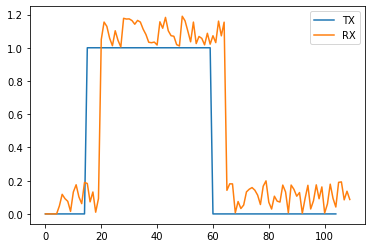

In [17]:
nSym = 5
samps_per_sym = 15
M = 2
syns = [0,1,1,1,0,0,0]
tx_sym = np.repeat(syns,samps_per_sym)
tx_noise = tx_sym + np.random.rand(len(tx_sym))/5

rx_sym_delay = numpy.concatenate([np.zeros(5),tx_noise])

sincSymbol(tx_sym, rx_sym_delay)

plt.plot(tx_sym, label = "TX")
plt.plot(rx_sym_delay, label = "RX")
plt.legend()
plt.show()


O que deve ser feito:
- Enviar uma série de bits ja conhecidos
- Com essa séria, demodular, verificar o sincronismo do clock e fazer a amostragem
- Teremos o I e Q amostrados
- Comparar com o I e Q originais
- Assim é possível saber o desvio de fase

## Curvas Teóricas

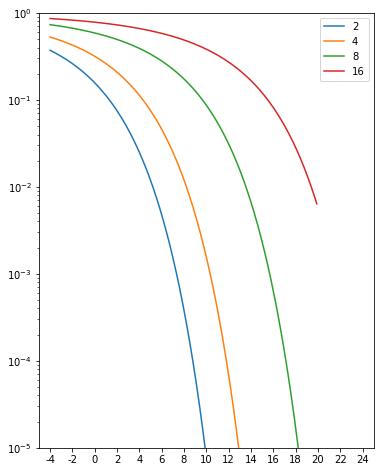

In [88]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Ms = [2, 4, 8, 16]
colors = {2: 'b', 4: 'r', 8: 'g', 16 : 'black'}
SNR_inicial = -4
SNR_final = 20
step = 4
EbN0dBs2 = np.arange(start=SNR_inicial,stop = SNR_final, step = 0.1)


fig, ax = plt.subplots(figsize=(6,8))
for M in Ms:

    BER_theory = 2*Q_function(np.sin(np.pi/M)*np.sqrt(10**(EbN0dBs2/10)*2))
    ax.semilogy(EbN0dBs2, BER_theory, label = str(M))
    ax.set_ylim([float(1e-5), float(1)])
    ax.set_xlim([-5, 25])
    ax.xaxis.grid(True, which='minor')
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    ax.legend()

# Modulação em banda base
O sistema em banda base é composto pelos seguintes blocos
<img src="./sistema.svg">
* Geração dos simbolos: *sym_gen*
* Modulação em banda base: *psk_mod_baseband*
* Resampling: *resampling*
* Filtro casado: *matched_filter_RC* e *apply_filter*
* Ruido: *channel_awgn*
* Amostragem: *sampling*
* Decisor: *decision*

É possível também calcular a SER utilizando a função *SER_calcu*

## Banda Base

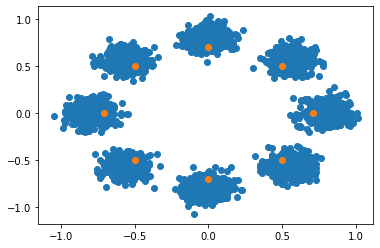

In [68]:
data_rate = 1000 #Symb/s
Ts = 1/data_rate
sample_rate = 20000
Fs = 1/sample_rate
samps_per_sym = int(Ts/Fs)
size = 3
alpha = 0.5
numSym = 3000
M = 8
EbNo = 20

#Generate data
data = sym_gen(numSym, M)

#Modulating the data
syms = psk_mod_baseband(data, M)

#Resampling the modulated data
syms_re = resampling(syms, samps_per_sym)

#Matched filter
filter_rc = matched_filter_RC(alpha, Ts, Fs, size)
wave = apply_mf(filter_rc, syms_re, Ts, Fs, size)

#Applying the noise
tx = channel_awgn(wave, EbNo, samps_per_sym)

#Receiving the data with Matched filter
rx = apply_mf(filter_rc, tx, Ts, Fs, size)

#Sampling the data
rx_sym = sampling(rx, samps_per_sym)[0:len(data)]

#Plotting the received data constelation
plot_constellation(rx_sym, M)

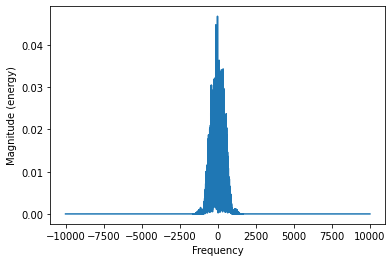

In [69]:
plt.magnitude_spectrum(wave, Fs=sample_rate);

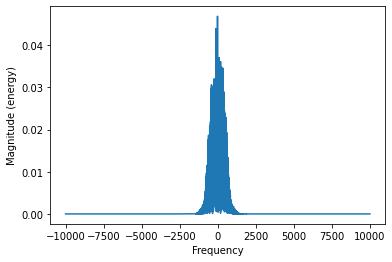

In [70]:
plt.magnitude_spectrum(rx, Fs=sample_rate);

# Modulação em banda passante

0.0

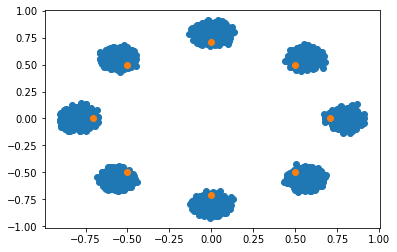

In [57]:
M = 8
data_rate = 5000 #symb/s
Ts = 1/data_rate
sample_rate = 60000
Fs = 1/sample_rate
samps_per_sym = Ts/Fs
size = 3
alpha = 0.5
numSym = 3000
EbNo = 30
f = 20000

#Generate data
data = sym_gen(numSym, M)

#Modulating the data
syms = psk_mod_baseband(data, M)

#Resampling the modulated data
syms_re = resampling(syms, samps_per_sym)

#Matched filter
filter_rc = matched_filter_RC(alpha, Ts, Fs, size)
wave = apply_mf(filter_rc, syms_re, Ts, Fs, size)

cos_wave = base_wave(sample_rate, f, (1/data_rate)*numSym, type_wave = 'cos', phase = 0)
sin_wave = base_wave(sample_rate, f, (1/data_rate)*numSym, type_wave = 'sin', phase = 0)

wave = wave.real*cos_wave-wave.imag*sin_wave

#Applying the noise
tx = channel_awgn(wave, EbNo, samps_per_sym)

bits_rx_cos = tx*cos_wave

bits_rx_sin = tx*-sin_wave


#Receiving the data with Matched filter
Q = apply_mf(filter_rc, bits_rx_cos, Ts, Fs, size)*2
I = apply_mf(filter_rc, bits_rx_sin, Ts, Fs, size)*2

rx = Q+1j*I

#Sampling the data
rx_sym = sampling(rx, samps_per_sym)[0:len(data)]

#Plotting the received data constelation
plot_constellation(rx_sym, M)

#SER (Symbol error rate)
SER_calc(rx_sym, data, constellation_psk(M))

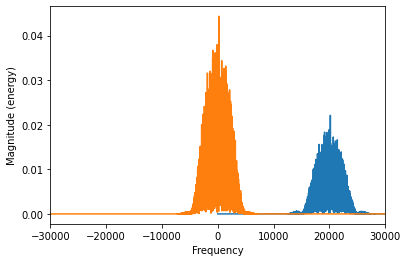

In [58]:
plt.magnitude_spectrum(wave, Fs=sample_rate);
plt.magnitude_spectrum(rx, Fs=sample_rate);
plt.xlim(-30000,30000);

## Simulação SER

In [ ]:
Ms = [2, 4, 8, 16]
colors = {2: 'b', 4: 'r', 8: 'g', 16 : 'black'}
SNR_inicial = -4
SNR_final = 20
step = 4
EbN0dBs = np.arange(start=SNR_inicial,stop = SNR_final, step = step) # Eb/N0 range in dB for simulation
EbN0dBs2 = np.arange(start=SNR_inicial,stop = SNR_final, step = 0.1)
fig = plt.subplots(figsize=(8,8))
data_rate = 1000 #Symb/s
Ts = 1/data_rate
sample_rate = 20000
Fs = 1/sample_rate
samps_per_sym = int(Ts/Fs)
size = 3
alpha = 0.5
numSym = 100000
f = 5000


for M in Ms:
   
    data = sym_gen(numSym, M)

    #Modulating the data
    syms = psk_mod_baseband(data, M)

    #Resampling the modulated data
    syms_re = resampling(syms, samps_per_sym)

    #Matched filter
    filter_rc = matched_filter_RC(alpha, Ts, Fs, size)
    wave = apply_mf(filter_rc, syms_re, Ts, Fs, size)

    cos_wave = base_wave(sample_rate, f, (1/data_rate)*numSym, type_wave = 'cos', phase = 0)
    sin_wave = base_wave(sample_rate, f, (1/data_rate)*numSym, type_wave = 'sin', phase = 0)

    wave = wave.real*cos_wave-wave.imag*sin_wave

    
    SER_values = np.zeros(len(EbN0dBs)) # simulated Bit error rates
    

    for j,EbN0dB in enumerate(EbN0dBs):
        clear_output(wait=True)
        print('{}-PSK'.format(M))
        print('SNR = {}'.format(EbN0dB))
        
        #Applying the noise
        tx = channel_awgn(wave, EbN0dB, samps_per_sym)

        bits_rx_cos = tx*cos_wave

        bits_rx_sin = tx*-sin_wave


        #Receiving the data with Matched filter
        Q = apply_mf(filter_rc, bits_rx_cos, Ts, Fs, size)*2
        I = apply_mf(filter_rc, bits_rx_sin, Ts, Fs, size)*2

        rx = Q+1j*I

        #Sampling the data
        rx_sym = sampling(rx, samps_per_sym)[0:len(data)]
        SER = SER_calc(rx_sym, data, constellation_psk(M))
        
        SER_values[j] = SER


    BER_theory = 2*Q_function(np.sin(np.pi/M)*np.sqrt(10**(EbN0dBs2/10)*2))

    plt.semilogy(EbN0dBs,SER_values,color=colors[M],marker='o',linestyle='')
    plt.semilogy(EbN0dBs2,BER_theory,color=colors[M], marker='',linestyle='-',label=str(M)+'-PSK')
    plt.xlim(-5,24);
    plt.ylim(1e-5,1)
    plt.grid(True);
    plt.xlabel('$E_s/N_0$')
    plt.legend()
